In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

In [7]:
df=pd.read_csv('Access_to_Care_Dataset.csv')

In [42]:
df_age=df[(df['GROUP']!='Age groups with 75 years and older') & (df['GROUP']!='Total')]
df_age['ESTIMATE'].dropna()

6         0.2
7         0.3
8         0.4
9         0.2
10        0.3
         ... 
26203    78.9
26204    77.0
26205    78.8
26206    80.5
26207    82.0
Name: ESTIMATE, Length: 22321, dtype: float64

We categorize the topics into five different categories: behavioral factors, cost, disability, insurance, and mental health.

In [43]:
target_topics = ['Current cigarette smoking','Current electronic cigarette or vaping product use',
                 'Obesity in adults, self-reported','Delayed getting medical care due to cost among adults',
                 'Did not get needed medical care due to cost','Did not get needed mental health care due to cost',
                 'Did not take medication as prescribed to save money','Any difficulty communicating',
                 'Any difficulty hearing','Any difficulty remembering or concentrating','Any difficulty seeing',
                 'Any difficulty walking or climbing steps','Any difficulty with self care',
                 'Disability status (composite) among adults','Functioning difficulties status (composite) among adults',
                 'Regularly experienced chronic pain','Six or more workdays missed due to illness, injury, or disability',
                 'Uninsured at time of interview among adults','Uninsured for at least part of the past year among adults',
                 'Uninsured for more than one year among adults','Counseled by a mental health professional',
                 'Regularly had feelings of depression','Regularly had feelings of worry, nervousness, or anxiety',
                 'Taking prescription medication for feelings of depression',
                 'Taking prescription medication for feelings of worry, nervousness, or anxiety']
category={'Current cigarette smoking':'behavioral factors',
          'Current electronic cigarette or vaping product use':'behavioral factors',
          'Obesity in adults, self-reported':'behavioral factors',
          'Delayed getting medical care due to cost among adults':'cost',
          'Did not get needed medical care due to cost':'cost',
          'Did not get needed mental health care due to cost':'cost',
          'Did not take medication as prescribed to save money':'cost',
          'Any difficulty communicating':'disability',
          'Any difficulty hearing':'disability',
          'Any difficulty remembering or concentrating':'disability',
          'Any difficulty seeing':'disability',
          'Any difficulty walking or climbing steps':'disability',
          'Any difficulty with self care':'disability',
          'Disability status (composite) among adults':'disability',
          'Functioning difficulties status (composite) among adults':'disability',
          'Regularly experienced chronic pain':'disability',
          'Six or more workdays missed due to illness, injury, or disability':'disability',
          'Uninsured at time of interview among adults':'insurance',
          'Uninsured for at least part of the past year among adults':'insurance',
          'Uninsured for more than one year among adults':'insurance',
          'Counseled by a mental health professional':'mental health',
          'Regularly had feelings of depression':'mental health',
          'Regularly had feelings of worry, nervousness, or anxiety':'mental health',
          'Taking prescription medication for feelings of depression':'mental health',
          'Taking prescription medication for feelings of worry, nervousness, or anxiety':'mental health'}

filtered_df = df_age[df_age['TOPIC'].isin(target_topics)]
filtered_df['TopicCategory']=filtered_df['TOPIC'].map(category)
filtered_df1=filtered_df[['TopicCategory','GROUP','SUBGROUP','ESTIMATE']]

print(filtered_df1.head())

    TopicCategory                               GROUP     SUBGROUP  ESTIMATE
942    disability  Age groups with 65 years and older  18-34 years       4.4
943    disability  Age groups with 65 years and older  18-34 years       4.3
944    disability  Age groups with 65 years and older  18-34 years       4.7
945    disability  Age groups with 65 years and older  18-34 years       5.3
946    disability  Age groups with 65 years and older  18-34 years       6.0


/tmp/ipykernel_187/667891513.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['TopicCategory']=filtered_df['TOPIC'].map(category)


In [63]:
cluster_input = filtered_df.pivot_table(
    index=['GROUP','SUBGROUP'], 
    columns='TopicCategory', 
    values='ESTIMATE', 
    aggfunc='mean'
)

In [64]:
cluster_input.isnull().sum()

TopicCategory
behavioral factors    0
cost                  0
disability            0
insurance             7
mental health         0
dtype: int64

In [65]:
X=cluster_input.fillna(cluster_input.mean())

Standardization of the estimation values

In [66]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Modeling
Decide the most appropriate value of k

In [67]:
cluster_input.isnull().sum()

TopicCategory
behavioral factors    0
cost                  0
disability            0
insurance             7
mental health         0
dtype: int64

In [68]:
inertia = []
K = range(2, 8)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

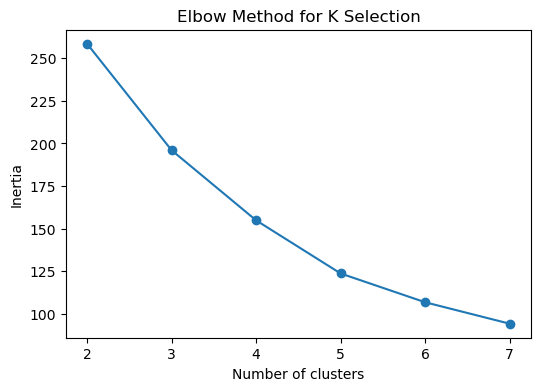

In [69]:
plt.figure(figsize=(6,4))
plt.plot(K, inertia, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for K Selection")
plt.show()

In [70]:
k = 5  
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
clusters = kmeans.fit_predict(X_scaled)

X_clustered = X.copy()
X_clustered["cluster"] = clusters

In [71]:
cluster_centers = (
    X_clustered
    .groupby("cluster")
    .mean()
)

In [72]:
ranked = cluster_centers.rank(ascending=True)
ranked["total_rank_score"] = ranked.sum(axis=1)

ranked.sort_values("total_rank_score")

TopicCategory,behavioral factors,cost,disability,insurance,mental health,total_rank_score
cluster,,,,,,
0,1.0,1.0,4.0,3.0,2.0,11.0
3,2.0,2.0,2.0,2.0,3.0,11.0
4,3.0,5.0,1.0,5.0,1.0,15.0
1,4.0,3.0,3.0,4.0,4.0,18.0
2,5.0,4.0,5.0,1.0,5.0,20.0


In [80]:
#most_vulnerable_cluster = ranked["total_rank_score"].idxmin()
most_vulnerable_cluster = ranked["total_rank_score"][0:0]
print("Most vulnerable cluster:", most_vulnerable_cluster)

Most vulnerable cluster: Series([], Name: total_rank_score, dtype: float64)


As cluster 0 and cluster 3 get the same rank score, we dive into both clusters to examine which subgroups belong to these respective groups.

cluster 3

In [86]:
vuln = X_clustered[X_clustered["cluster"] == 3]

In [87]:
vuln["risk_score"] = vuln.drop(columns="cluster").mean(axis=1)

/tmp/ipykernel_187/62111146.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vuln["risk_score"] = vuln.drop(columns="cluster").mean(axis=1)


In [88]:
vuln_reset = vuln.reset_index()

top_subgroups = (
    vuln_reset.loc[
        vuln_reset.groupby("GROUP")["risk_score"].idxmax()
    ]
    .sort_values("risk_score", ascending=False)
)

In [89]:
top_subgroups

TopicCategory,GROUP,SUBGROUP,behavioral factors,cost,disability,insurance,mental health,cluster,risk_score
23,Race and Hispanic origin,"All races, Hispanic, Mexican",17.072222,8.979167,13.610345,30.205556,6.506667,3,15.274791
5,Education,High school diploma or GED,21.227778,7.100000,20.003448,16.994444,9.993333,3,15.063801
30,Region,South,18.116667,8.050000,17.341379,17.416667,10.296667,3,14.244276
35,Social vulnerability,High social vulnerability,17.438889,7.304167,17.003448,16.461111,9.476667,3,13.536856
15,Metropolitan statistical area,Small MSA,17.933333,7.279167,17.846552,12.961111,11.360000,3,13.476033
41,Urbanicity,Medium and small metro,17.894444,7.245833,17.832759,13.016667,11.350000,3,13.467941
32,Sex,Female,15.988889,7.933333,17.789655,11.277778,13.316667,3,13.261264
13,Marital status,Never married,16.844444,7.820833,13.960345,14.627778,12.416667,3,13.134013
20,Race,Black only,19.816667,8.025000,16.486207,12.994444,8.330000,3,13.130464
1,Age groups with 65 years and older,35-49 years,19.316667,8.525000,12.275862,13.727778,10.943333,3,12.957728


cluster 0

In [90]:
vuln = X_clustered[X_clustered["cluster"] == 0]

In [91]:
vuln["risk_score"] = vuln.drop(columns="cluster").mean(axis=1)

/tmp/ipykernel_187/62111146.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vuln["risk_score"] = vuln.drop(columns="cluster").mean(axis=1)


In [92]:
vuln_reset = vuln.reset_index()

top_subgroups = (
    vuln_reset.loc[
        vuln_reset.groupby("GROUP")["risk_score"].idxmax()
    ]
    .sort_values("risk_score", ascending=False)
)

In [93]:
top_subgroups

TopicCategory,GROUP,SUBGROUP,behavioral factors,cost,disability,insurance,mental health,cluster,risk_score
5,Health insurance coverage: 65 years and older,Medicare and Medicaid,16.922222,2.625000,40.292453,14.714239,13.310000,0,17.572783
3,Employment status,Not employed - Has worked previously,16.577778,6.241667,25.193103,14.405556,13.146667,0,15.112954
10,Marital status,Widowed,14.755556,4.037500,31.044828,13.405556,10.733333,0,14.795354
0,Age groups with 65 years and older,65 years and older,12.900000,2.666667,26.739655,14.714239,8.176667,0,13.039445
11,Veteran status,Veteran,18.177778,3.866667,24.201724,5.527778,10.303333,0,12.415456
